# Sound Classification with CNN

Train a CNN model to identify frog species from field recordings. Output classes include five frog species, _Bufo japonicus_(Bjap), _Dryophytes japonicus_(Djap), _Glandirana rugosa_(Grug), _Pelophylax nigromaculatus_(Pnig), and _Zhangixalus schlegelii_(Zsch), as well as background noise.

We used [fastai](https://www.fast.ai/) library for model training and evalutation.

In [15]:
from fastai.vision.all import *
import sklearn.metrics as skm

## Model training

First, check the number of training and validation samples.

In [16]:
# Build datablock
def get_multi_y(x): return parent_label(x).split("_")

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   get_items = get_image_files,
                   get_y = get_multi_y,
                   splitter = GrandparentSplitter(train_name="train", valid_name="valid")
                   )

dsets = dblock.datasets("training/high-pass")

print("Training dataset: ", len(dsets.train))
print("Validation dataset: ", len(dsets.valid))
print("Type of data: ", dsets.valid[0])

Training dataset:  2565
Validation dataset:  190
Type of data:  (PILImage mode=RGB size=861x112, TensorMultiCategory([0., 0., 0., 0., 0., 1.]))


The following images are examples of the spectrograms used for training.

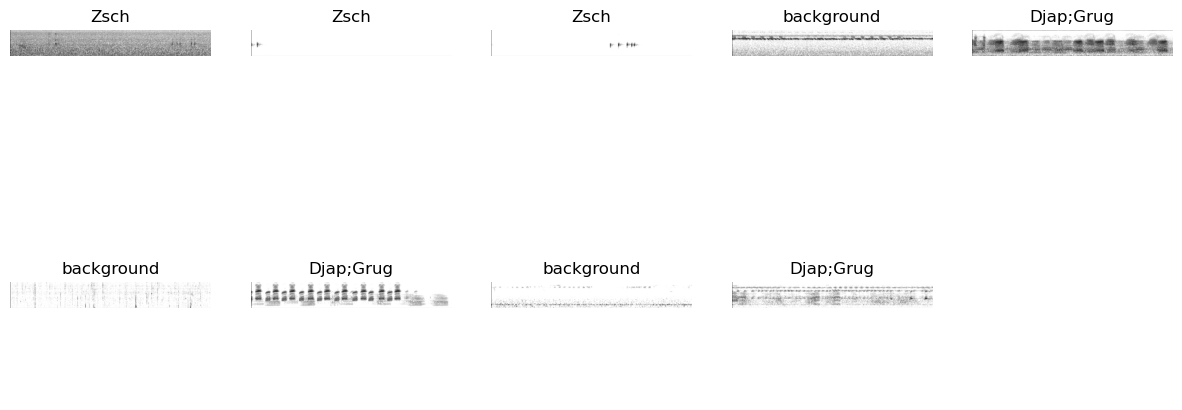

In [17]:
# DataLoaders
dls = dblock.dataloaders("training/high-pass")
dls.train.show_batch(nrows=2)

Now train the ResNet18 model with the above dataset.

In [18]:
# Model training
learn =vision_learner(dls, models.resnet18, metrics=accuracy_multi, pretrained = True, normalize = True)

start_time = time.time()
with learn.no_bar(), learn.no_logging(): learn.fine_tune(epochs=150, freeze_epochs=10, cbs=MixUp()) 
end_time = time.time()
print("Time elapsed: ", end_time - start_time) 

Time elapsed:  4161.8683161735535


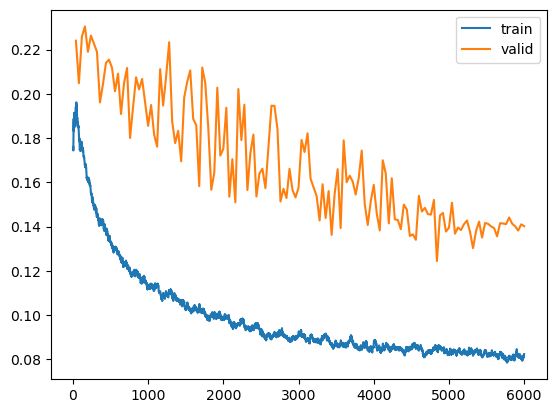

In [19]:
learn.recorder.plot_loss()

In this case, the training process took about 70 minutes.

## Model metrics

Calculate the model performance using the scikit-learn `classification_report` and `roc_auc_score` functions. Values can be slightly diffrent from the published article due to the randomness in the training process.

In [21]:
preds, targ = learn.get_preds(ds_idx=1)

print(skm.classification_report(targ[:,:5], preds[:,:5]>0.5, target_names=dls.vocab[:5], zero_division = 0.0))
print("AUC score" + str(skm.roc_auc_score(targ, preds, average="macro")))

              precision    recall  f1-score   support

        Bjap       1.00      0.90      0.95        40
        Djap       1.00      0.93      0.96        40
        Grug       0.91      0.75      0.82        40
        Pnig       0.91      0.75      0.82        40
        Zsch       1.00      0.97      0.99        40

   micro avg       0.97      0.86      0.91       200
   macro avg       0.96      0.86      0.91       200
weighted avg       0.96      0.86      0.91       200
 samples avg       0.70      0.68      0.68       200

AUC score0.9840833333333333


In [14]:
learn.export("output/20220103_trained-model.pkl")  # Save the model